# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part III

This notebook continues the work done in Part I and II, this time focusing on building the best classification model to help differentiate violation cannabis possession from the four other types of cannabis crime in New York City between 2006-2018: misdemeanor possession, felony possession, misdemeanor sales, and felony sales. This notebook continues to explore the line between cannabis possession and sales crimes at a greater level of granularity, while aiming to discover the most salient coefficients of the classification models to uncover the features of the dataset with the strongest relationship to violation cannabis possession.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils import resample

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

A flow chart of the machine learning pipeline for classifying violation possession crimes from all other cannabis crimes in New York City between 2006 and 2018 is visualized below. The final outcome of which algorithm performed best is included in this visualization.

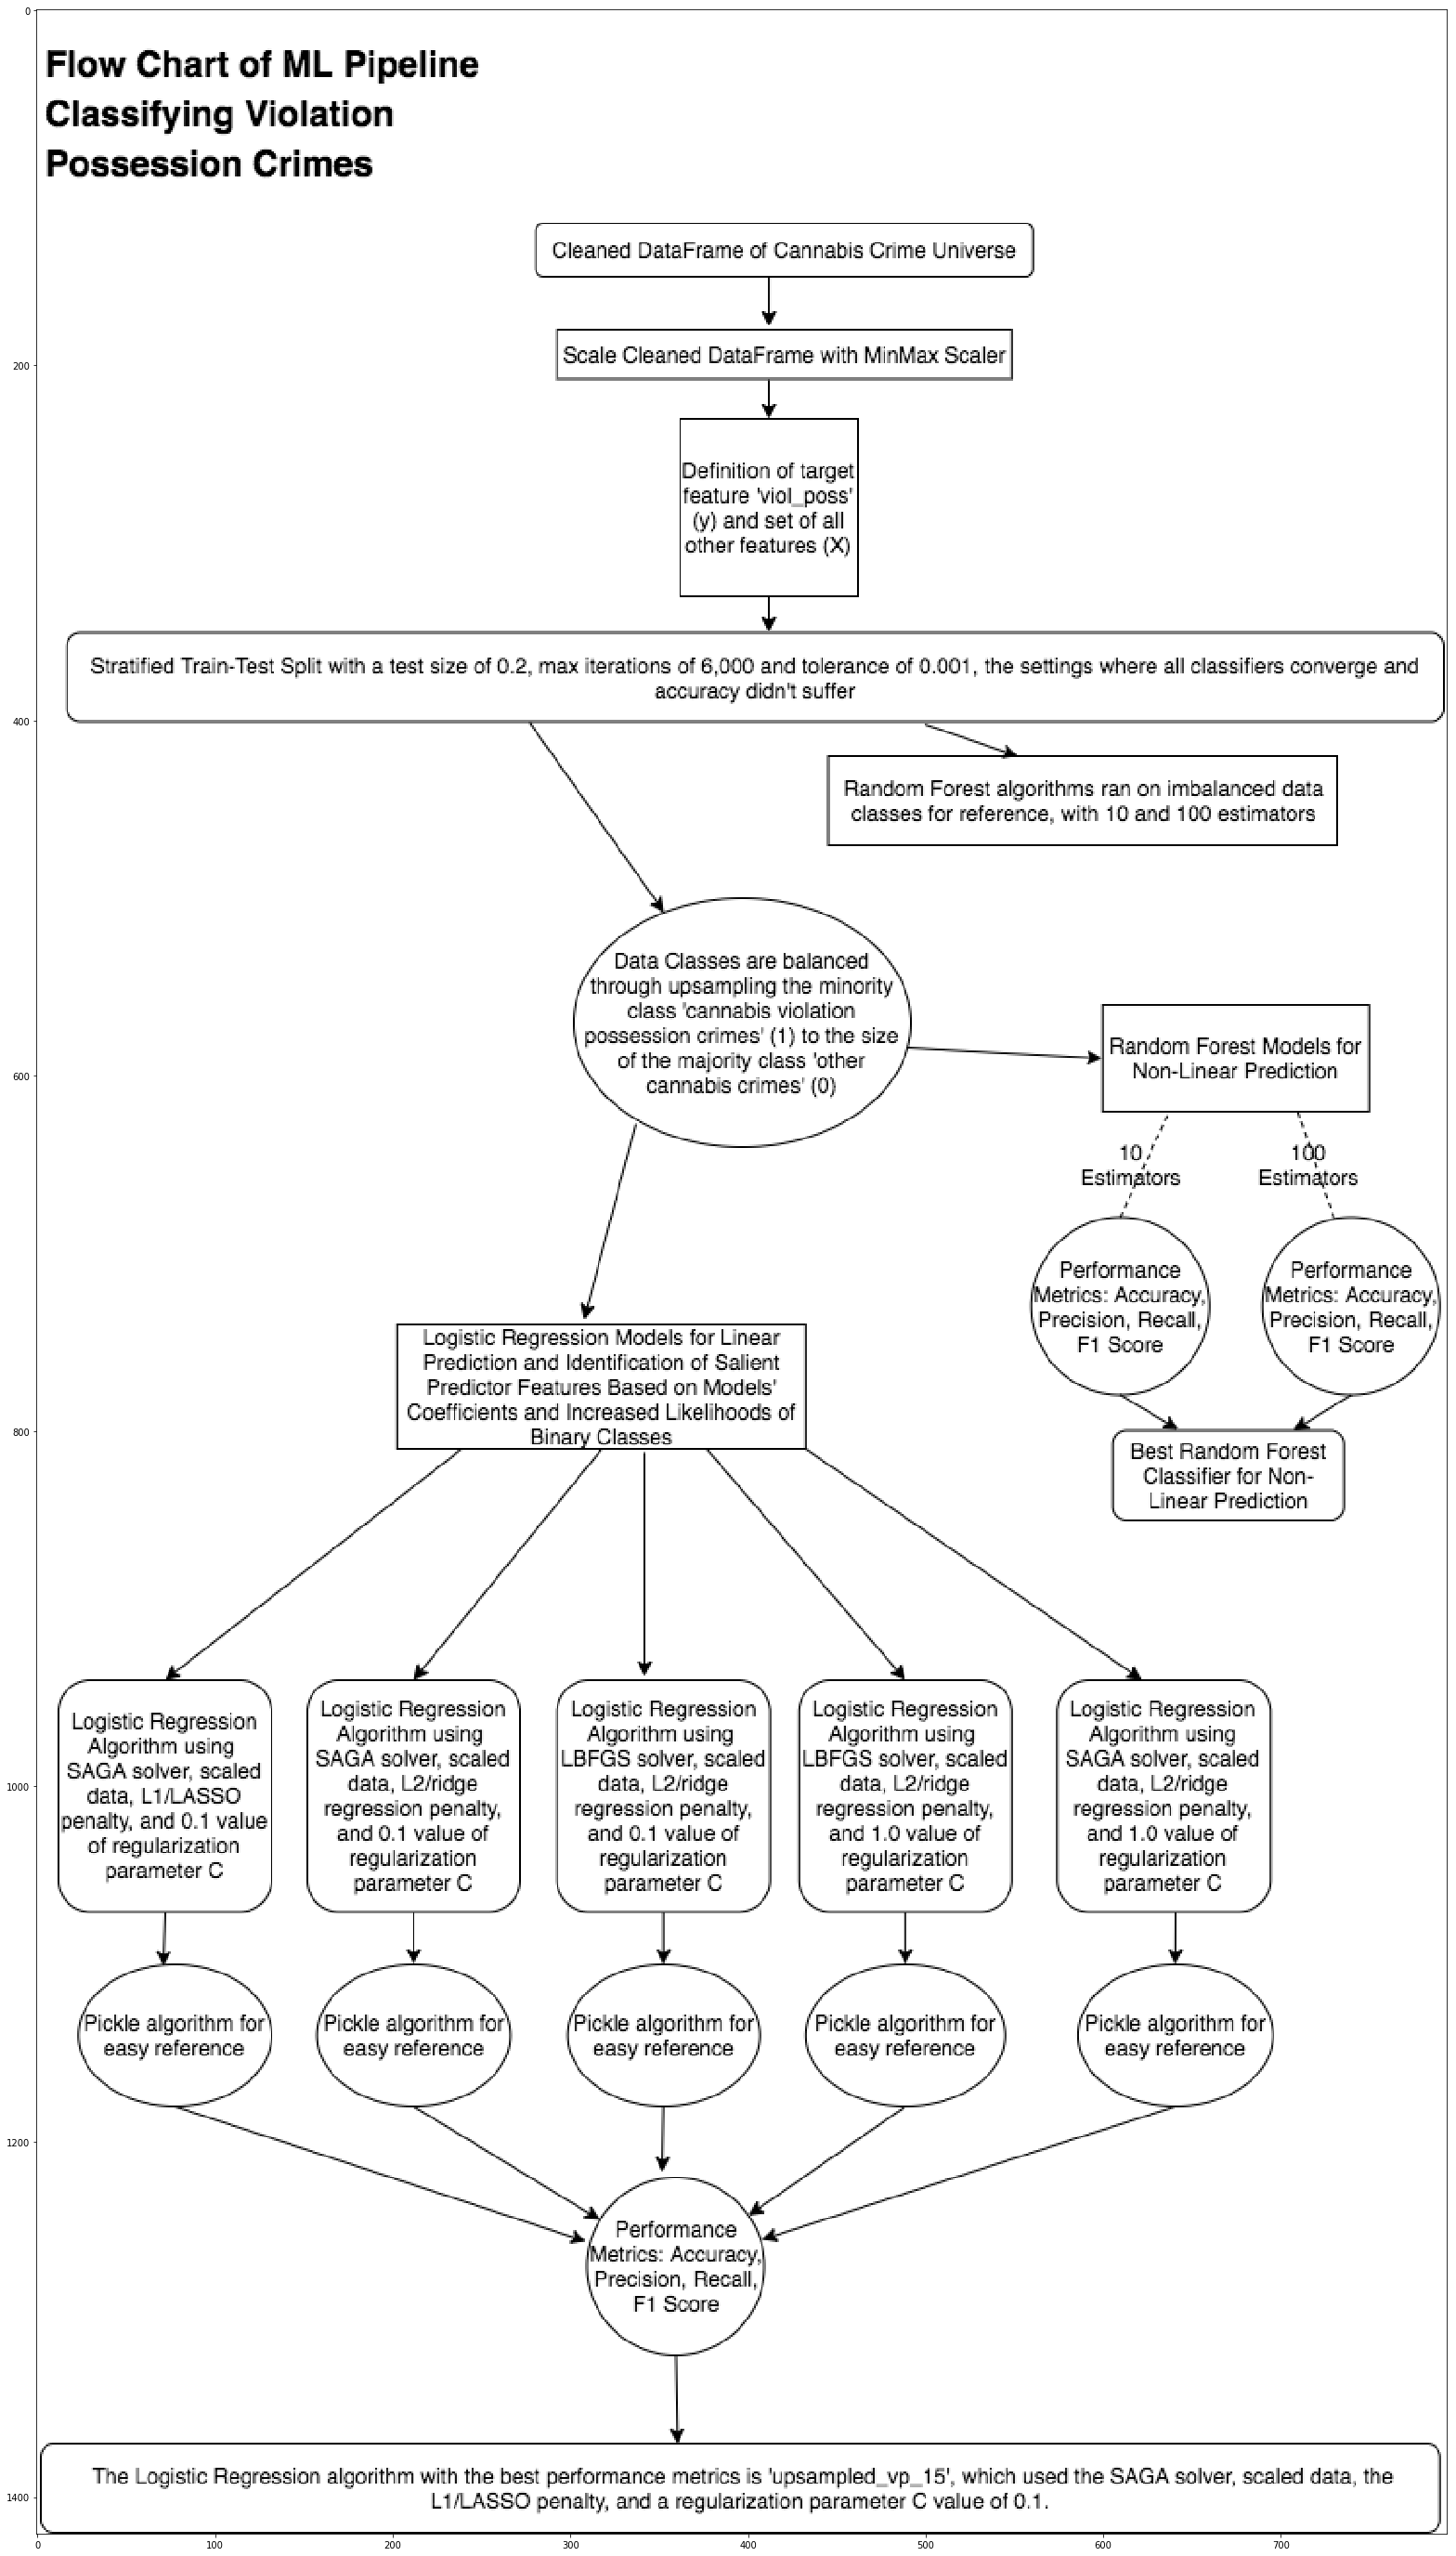

In [3]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("Violation Possession ML Pipeline.png")
implot = plt.imshow(im)

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

# Violation Possession Crimes

The violation possession cases have a value of '1' in the 'viol_poss' feature, and all other cannabis crimes have a value of '0'. Because this round of classification is focused on violation possession cannabis crimes versus all other cannabis crimes, a set of features that also describe the type of crime must be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell, which also creates a subsetted DataFrame for use in classifying violation possession crimes. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebooks for the creation of the cannabis/non-cannabis DataFrame).

In [4]:
df_vp = df.drop(columns = ['CMPLNT_NUM', 'possession', 'misd_poss', 'felony_poss', 'misd_sales', 'felony_sales'])

In [5]:
df_vp['viol_poss'].value_counts()

0    213520
1      6784
Name: viol_poss, dtype: int64

The .head() method are called on the 'df_vp' DataFrame for reference.

In [7]:
df_vp.head()

,Latitude,Longitude,viol_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PR

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data.

In [6]:
scaler = MinMaxScaler()

In [7]:
scaler.fit(df_vp)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
df_vp_scaled = pd.DataFrame(scaler.transform(df_vp), columns=df_vp.columns, index=df_vp.index)

In [11]:
df_vp_scaled.head()

,Latitude,Longitude,viol_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PR

The target feature in this series of classifications is the binary feature 'viol_poss', with a value of 1 for violation cannabis crimes and 0 for all other cannabis crimes. The target feature is assigned to y.

In [9]:
y = df_vp_scaled['viol_poss']

The feature set is assigned to X, which includes all features in the 'df_vp_scaled' DataFrame which are not the target.

In [10]:
target_names = ['viol_poss']
X = df_vp_scaled[[cn for cn in df_vp_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Random Forest Algorithm

The Random Forest classifier is carried out on the violation possession crimes below on the original training set as an experiment, first with 10 estimators and then 100.

In [107]:
rfc_vp_1 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [111]:
rfc_vp_pred_1 = rfc_vp_1.predict(X_test)
rfc_vp_pred_1[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.])

In [109]:
accuracy_score(y_test, rfc_vp_pred_1)

0.9728785093393251

The confusion matrix shows that there are 42,513 true positives, 1,004 false positives, 191 false negatives, and 353 true negatives.

In [112]:
confusion_matrix(y_test, rfc_vp_pred_1)

array([[42513,   191],
       [ 1004,   353]])

In [113]:
print(classification_report(y_test, rfc_vp_pred_1))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     42704
         1.0       0.65      0.26      0.37      1357

   micro avg       0.97      0.97      0.97     44061
   macro avg       0.81      0.63      0.68     44061
weighted avg       0.97      0.97      0.97     44061



In [114]:
filename = 'rfc_vp_1.sav'
pickle.dump(rfc_vp_1, open(filename, 'wb'))

The accuracy and weighted averages for precision, recall, and F1 score are all quite high, but the model is much worse at predicting violation possession charges than other types of cannabis crimes. This is to be expected with imbalanced data classes to some extent, but makes the case for upsampling the minority class.

In [115]:
rfc_vp_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [116]:
rfc_vp_pred_2 = rfc_vp_2.predict(X_test)

In [117]:
accuracy_score(y_test, rfc_vp_pred_2)

0.9737182542384422

The confusion matrix shows that there are 42,526 true positives, 980 false positives, 178 false negatives, and 377 true negatives.

In [118]:
confusion_matrix(y_test, rfc_vp_pred_2)

array([[42526,   178],
       [  980,   377]])

In [119]:
print(classification_report(y_test, rfc_vp_pred_2))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     42704
         1.0       0.68      0.28      0.39      1357

   micro avg       0.97      0.97      0.97     44061
   macro avg       0.83      0.64      0.69     44061
weighted avg       0.97      0.97      0.97     44061



In [120]:
filename = 'rfc_vp_2.sav'
pickle.dump(rfc_vp_2, open(filename, 'wb'))

The RandomForest classifier with 100 estimators does perform better than with 10 estimators, but not by much.

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [12]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [13]:
not_viol_poss = X[X.viol_poss == 0]
viol_poss = X[X.viol_poss == 1]

Then, the minority class (i.e., viol_poss) is upsampled.

In [14]:
viol_poss_upsampled = resample(viol_poss,
                          replace=True, # sample with replacement
                          n_samples=len(not_viol_poss), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [15]:
upsampled_vp = pd.concat([not_viol_poss, viol_poss_upsampled])

The new class counts are checked.

In [16]:
upsampled_vp.viol_poss.value_counts()

1.0    170816
0.0    170816
Name: viol_poss, dtype: int64

The 'y_train' target and 'X_train' feature set are then re-defined.

In [17]:
y_train = upsampled_vp.viol_poss

In [18]:
X_train = upsampled_vp.drop('viol_poss', axis=1)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the top performing LogisticRegression algorithms from the cannabis possession and sales classification are run. The numbering scheme for the models from Part II is maintained (with the addition of the suffix '_vp'), for the sake of ease of reference.

In [19]:
upsampled_vp_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [20]:
upsampled_vp_pred_15 = upsampled_vp_15.predict(X_test)
upsampled_vp_pred_15[0:35]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0.])

In [56]:
accuracy_score(y_test, upsampled_vp_pred_15)

0.8130546288100587

The confusion matrix shows that there are 39,437 true positives, 470 false positives, 7,767 false negatives, and 887 true negatives.

In [57]:
confusion_matrix(y_test, upsampled_vp_pred_15)

array([[34937,  7767],
       [  470,   887]])

In [58]:
print(classification_report(y_test, upsampled_vp_pred_15))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     42704
         1.0       0.10      0.65      0.18      1357

   micro avg       0.81      0.81      0.81     44061
   macro avg       0.54      0.74      0.54     44061
weighted avg       0.96      0.81      0.87     44061



In [133]:
filename = 'upsampled_vp_15.sav'
pickle.dump(upsampled_vp_15, open(filename, 'wb'))

In [134]:
upsampled_vp_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [135]:
upsampled_vp_pred_9 = upsampled_vp_9.predict(X_test)
upsampled_vp_pred_9[0:35]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0.])

In [136]:
accuracy_score(y_test, upsampled_vp_pred_9)

0.812895758153469

The confusion matrix shows that there are 34,932 true positives, 472 false positives, 7,772 false negatives, and 885 true negatives.

In [137]:
confusion_matrix(y_test, upsampled_vp_pred_9)

array([[34932,  7772],
       [  472,   885]])

In [138]:
print(classification_report(y_test, upsampled_vp_pred_9))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     42704
         1.0       0.10      0.65      0.18      1357

   micro avg       0.81      0.81      0.81     44061
   macro avg       0.54      0.74      0.54     44061
weighted avg       0.96      0.81      0.87     44061



In [139]:
filename = 'upsampled_vp_9.sav'
pickle.dump(upsampled_vp_9, open(filename, 'wb'))

In [140]:
upsampled_vp_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [141]:
upsampled_vp_pred_1 = upsampled_vp_1.predict(X_test)
upsampled_vp_pred_1[0:35]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0.])

In [142]:
accuracy_score(y_test, upsampled_vp_pred_1)

0.8129184539615533

The confusion matrix shows that there are 34,932 true positives, 471 false positives, 7,772 false negatives, and 886 true negatives.

In [143]:
confusion_matrix(y_test, upsampled_vp_pred_1)

array([[34932,  7772],
       [  471,   886]])

In [144]:
print(classification_report(y_test, upsampled_vp_pred_1))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     42704
         1.0       0.10      0.65      0.18      1357

   micro avg       0.81      0.81      0.81     44061
   macro avg       0.54      0.74      0.54     44061
weighted avg       0.96      0.81      0.87     44061



In [145]:
filename = 'upsampled_vp_1.sav'
pickle.dump(upsampled_vp_1, open(filename, 'wb'))

In [146]:
upsampled_vp_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [147]:
upsampled_vp_pred_4 = upsampled_vp_4.predict(X_test)
upsampled_vp_pred_4[0:35]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0.])

In [148]:
accuracy_score(y_test, upsampled_vp_pred_4)

0.8115340096684143

The confusion matrix shows that there are 34,877 true positives, 477 false positives, 7,827 false negatives, and 880 true negatives.

In [149]:
confusion_matrix(y_test, upsampled_vp_pred_4)

array([[34877,  7827],
       [  477,   880]])

In [150]:
print(classification_report(y_test, upsampled_vp_pred_4))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     42704
         1.0       0.10      0.65      0.17      1357

   micro avg       0.81      0.81      0.81     44061
   macro avg       0.54      0.73      0.53     44061
weighted avg       0.96      0.81      0.87     44061



In [151]:
filename = 'upsampled_vp_4.sav'
pickle.dump(upsampled_vp_4, open(filename, 'wb'))

In [152]:
upsampled_vp_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [153]:
upsampled_vp_pred_10 = upsampled_vp_10.predict(X_test)
upsampled_vp_pred_10[0:35]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0.])

In [154]:
accuracy_score(y_test, upsampled_vp_pred_10)

0.8113524432037402

The confusion matrix shows that there are 34,869 true positives, 477 false positives, 7,835 false negatives, and 880 true negatives.

In [155]:
confusion_matrix(y_test, upsampled_vp_pred_10)

array([[34869,  7835],
       [  477,   880]])

In [156]:
print(classification_report(y_test, upsampled_vp_pred_10))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     42704
         1.0       0.10      0.65      0.17      1357

   micro avg       0.81      0.81      0.81     44061
   macro avg       0.54      0.73      0.53     44061
weighted avg       0.96      0.81      0.87     44061



In [157]:
filename = 'upsampled_vp_10.sav'
pickle.dump(upsampled_vp_10, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_vp_15', which uses the 'saga' solver, L1 penalty, and a C value of 0.1. This will be used to call the coefficients for the feature set.

## Random Forest Algorithm on Upsampled Training Data

A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [158]:
rfc_vp_3 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [159]:
rfc_vp_pred_3 = rfc_vp_3.predict(X_test)
rfc_vp_pred_3[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.])

In [160]:
accuracy_score(y_test, rfc_vp_pred_3)

0.9695195297428565

The confusion matrix shows that there are 42,306 true positives, 945 false positives, 398 false negatives, and 412 true negatives.

In [161]:
confusion_matrix(y_test, rfc_vp_pred_3)

array([[42306,   398],
       [  945,   412]])

In [162]:
print(classification_report(y_test, rfc_vp_pred_3))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     42704
         1.0       0.51      0.30      0.38      1357

   micro avg       0.97      0.97      0.97     44061
   macro avg       0.74      0.65      0.68     44061
weighted avg       0.96      0.97      0.97     44061



In [163]:
filename = 'viol_poss_rfc_3.sav'
pickle.dump(rfc_vp_3, open(filename, 'wb'))

In [164]:
rfc_vp_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [165]:
rfc_vp_pred_4 = rfc_vp_4.predict(X_test)
rfc_vp_pred_4[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.])

In [166]:
accuracy_score(y_test, rfc_vp_pred_4)

0.9709947572683325

The confusion matrix shows that there are 42,348 true positives, 922 false positives, 356 false negatives, and 435 true negatives.

In [167]:
confusion_matrix(y_test, rfc_vp_pred_4)

array([[42348,   356],
       [  922,   435]])

In [168]:
print(classification_report(y_test, rfc_vp_pred_4))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     42704
         1.0       0.55      0.32      0.41      1357

   micro avg       0.97      0.97      0.97     44061
   macro avg       0.76      0.66      0.70     44061
weighted avg       0.97      0.97      0.97     44061



In [169]:
filename = 'viol_poss_rfc_4.sav'
pickle.dump(rfc_vp_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Violation Possession Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_vp_15' LogisticRegression algorithm is recall (or true positive rate) for the violation possession cannabis crimes (0.32 vs. 0.65). The Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_vp_15' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis violation possession crimes from all other cannabis crimes. The hyperparameter tuning table for violation cannabis possession crimes and all other cannabis crimes is shown below, for reference.

In [59]:
viol_poss_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Viol_Poss')
viol_poss_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Not_Viol_Poss,Precision_Viol_Poss,Precision_Wtd_Average,Recall_Not_Viol_Poss,Recall_Viol_Poss,Recall_Wtd_Average,F1_Score_Not_Viol_Poss,F1_Score_Viol_Poss,F1_Score_Wtd_Average,Support_Not_Viol_Poss,Support_Viol_Poss,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_vp_pred_4,0.970995,0.98,0.55,0.97,0.99,0.32,0.97,0.99,0.41,0.97,42704,1357,44061
1,"RF, scaled, 10 n_estimators",rfc_vp_pred_3,0.969520,0.98,0.51,0.96,0.99,0.30,0.97,0.98,0.38,0.97,42704,1357,44061
2,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_vp_15,0.813055,0.99,0.10,0.96,0.82,0.65,0.81,0.89,0.18,0.87,42704,1357,44061
3,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_vp_1,0.812918,0.99,0.10,0.96,0.82,0.65,0.81,0.89,0.18,0.87,42704,1357,44061
4,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_vp_9,0.812896,0.99,0.10,0.96,0.82,0.65,0.81,0.89,0.18,0.87,42704,1357,44061
5,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_vp_4,0.811534,0.99,0.10,0.96,0.82,0.65,0.81,0.89,0.17,0.87,42704,1357,44061
6,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_vp_10,0.811352,0.99,0.10,0.96,0.82,0.65,0.81,0.89,0.17,0.87,42704,1357,44061
7,IMBALANCED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42704,1357,44061
8,"RandomForest, 10 estimators",rfc_vp1,0.972879,0.98,0.65,0.97,1.00,0.26,0.97,0.99,0.37,0.97,42704,1357,44061
9,"RandomForest, 100 estimators",rfc_vp2,0.973718,0.98,0.68,0.97,1.00,0.28,0.97,0.99,0.39,0.97,42704,1357,44061


## ROC curve and AUC

The best Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the 'upsampled_vp_15' LogisticRegression algorithm. This is done to further evaluate the model.

In [171]:
y_pred_prob_rfc_vp_4 = rfc_vp_4.predict_proba(X_test)[:,1]
y_pred_prob_rfc_vp_4

array([0.1 , 0.  , 0.03, ..., 0.  , 0.11, 0.  ])

In [172]:
fpr_rfc_vp_4, tpr_rfc_vp_4, thresholds_rfc_vp_4 = roc_curve(y_test, y_pred_prob_rfc_vp_4)

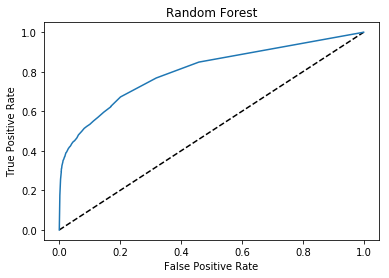

In [173]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_vp_4, tpr_rfc_vp_4, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [174]:
auc_score_rfc_upsampled_vp_15 = roc_auc_score(y_test, y_pred_prob_rfc_upsampled_vp_15)
auc_score_rfc_upsampled_vp_15

0.8028864286398627

In [55]:
y_pred_prob_upsampled_vp_15 = upsampled_vp_15.predict_proba(X_test)[:,1]
y_pred_prob_upsampled_vp_15

array([0.26588519, 0.16799519, 0.19271434, ..., 0.20859855, 0.99074497,
       0.37817863])

In [56]:
fpr_upsampled_vp_15, tpr_upsampled_vp_15, thresholds_upsampled_vp_15 = roc_curve(y_test, y_pred_prob_upsampled_vp_15)

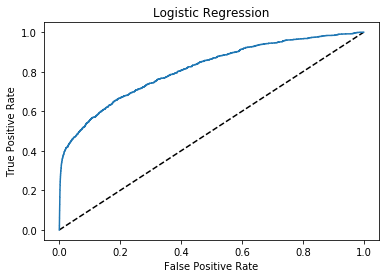

In [57]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_upsampled_vp_15, tpr_upsampled_vp_15, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [58]:
auc_score_upsampled_vp_15 = roc_auc_score(y_test, y_pred_prob_upsampled_vp_15)
auc_score_upsampled_vp_15

0.8130472798580166

The 'upsampled_vp_15' LogisticRegression algorithm has a slightly higher AUC score than the Random Forest algorithm with 100 estimators.

## Precision Recall Curve

Because of the imbalanced class count, the 15th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve.

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [59]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_upsampled_vp_15)

In [60]:
lr_vp_f1, lr_vp_auc = f1_score(y_test, upsampled_vp_pred_15), auc(lr_recall, lr_precision)

The scores are then summarized.

In [61]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_vp_f1, lr_vp_auc))

Logistic: f1=0.177 auc=0.338


The precision-recall curve is then plotted for the best Logistic Regression algorithm. The precision-recall curve's AUC is quite low, showing that the model does not have a good harmonic average of precision and recall for violation possession crimes but is moderately skillful at predicting other cannabis crimes as a group.

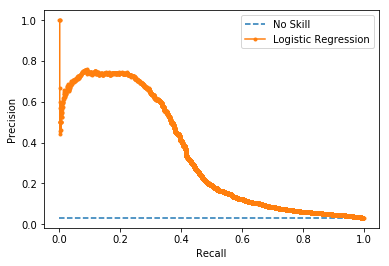

In [62]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models for Violation Possession

The best LogisticRegression model ('upsampled_vp_15') has an accuracy of 0.813054628810058, showing that it makes correct predictions on roughly 81.3% of the data points in the DataFrame.

The model's precision is 0.10 for the violation possession class (the 1 class), 0.99 for the other cannabis crime types class (the 0 class), and 0.96 on weighted average, showing that 10% of predicted violation possession crimes are actual violation possession crimes, 99% of predicted other cannabis crimes are actual other cannabis crimes, and 96% of cannabis crimes on weighted average are predicted correctly. 

The model's recall is 0.65 for the violation possession class (the 1 class), 0.82 for the other cannabis crime types class (0), and 0.81 on weighted average, showing that 65% of actual violation possession crimes are predicted as violation possession crimes, 82% of actual other cannabis crimes are predicted as other cannabis crimes, and that 81% of cannabis crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.18 for the violation possession class, 0.89 for the other cannabis crimes class, and 0.87 on weighted average. This metric is more informative than precision or recall alone, and shows that 18% of violation possession crimes and 89% of other cannabis crimes are being predicted correctly, for a weighted average of 87%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_vp_15') has an ROC AUC score of 81.3%, showing that it is a moderately skillful model in predicting violation possession crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 33.8%. The lower Precision Recall AUC score shows that the model is not very skilled at differentiating true positives from false positives and false negatives, especially for the violation possession class. However, as is shown above, it is more skillful at predicting the other cannabis crime types as a group. 

The RandomForest model with 100 estimators has an accuracy of 0.970994757268332. It has a 0.55 precision score for the violation possession class, a 0.98 precision score for the other crime types class, and a weighted average precision score of 0.97. The model has a recall score of 0.32 for the violation possession class, a 0.99 recall score for the other crime types class, and a weighted average recall score of 0.97. It has a 0.41 F1 score for the violation possession class, a 0.99 F1 score for the other crime types class, and a weighted average F1 score of 0.97. The ROC curve plotted above shows that it has an AUC score of 80.3%. This is not a very skillful model at predicting violation possession crimes. 

## Coefficients for Violation Possession

As detailed above, the F1 score for the violation possession class is only 0.18 when using the best performing Logistic Regression algorithm 'upsampled_vp_15'. However, the coefficients can still be valuable in identifying salient features of violation possession crimes to a certain degree if the F1 score is higher than zero. The only scenario where the coefficients would definitely not be valuable is if the algorithm only or almost only predicts one class. To check on whether the algorithm predicts both classes, and not just one, the predicted values 'upsampled_vp_pred_15' are converted to a Pandas Series and then its value counts are called. As can be seen, the violation possession class is predicted 8,654 times and the other cannabis crime types as a group are predicted 35,407 times. Therefore, the coefficients for the violation possession class are valuable and are called and analyzed below.

In [28]:
upsampled_vp_pred_15_s = pd.Series(upsampled_vp_pred_15)
upsampled_vp_pred_15_s.value_counts()

0.0    35407
1.0     8654
dtype: int64

In order to look at the most salient predictors of cannabis violation possession crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_vp_15') are identified to find the most predictive features differentiating cannabis violation  possession crimes from all other cannabis crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_vp_coeffs' (short for 'best classifier's coefficients').

In [21]:
best_cf_vp_coeffs = pd.Series(upsampled_vp_15.coef_[0], index=X_train.columns) 
best_cf_vp_coeffs

Latitude                                                                       -1.733549e-08
Longitude                                                                      -1.526578e-07
duration_days                                                                   0.000000e+00
start_year                                                                      2.969455e-01
start_month                                                                    -2.181186e-01
start_day                                                                       4.820126e-03
start_hour                                                                     -6.770223e-01
start_minute                                                                   -1.340343e-01
start_seconds                                                                   0.000000e+00
rpt_cmplnt_dt_match                                                            -2.892860e-01
day_tw                                                                

The features' coefficients are then sorted to show the features most predictive of cannabis violation possession crimes. The features with positive coefficients are more predictive of violation possession crimes, while the features with negative coefficients are more predictive of all other cannabis crimes. Because the '0' class, i.e. "all other cannabis crimes", is non-differentiated, there is no real value to the negative coefficients and they will be ignored.

In [22]:
sorted_best_cf_vp_coeffs = best_cf_vp_coeffs.sort_values()
sorted_best_cf_vp_coeffs

prospect_pk_l1                                                                 -3.847313e+00
PREM_TYP_DESC_MARINA/PIER                                                      -2.831774e+00
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)                                           -2.315997e+00
HADEVELOPT_WYCKOFF GARDENS                                                     -2.068903e+00
HADEVELOPT_RANGEL                                                              -1.965132e+00
HADEVELOPT_STUYVESANT GARDENS I                                                -1.839300e+00
HADEVELOPT_ADAMS                                                               -1.668437e+00
queens_l1                                                                      -1.643790e+00
HADEVELOPT_PATTERSON                                                           -1.614513e+00
halloween                                                                      -1.563460e+00
JURIS_DESC_N.Y. STATE POLICE                                          

To look at which features have the strongest relationship to violation possession, the features that have at least a 0.7209657 coefficient are called and speculated on below by assigning the object 'sorted_best_cf_vp_coeffs'. When exponentiated by assigning the object 'cannabis_vp_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a crime being a violation possession crime.

In [23]:
cannabis_vp_coeffs = sorted_best_cf_vp_coeffs[-82:].sort_values(ascending=False)
cannabis_vp_coeffs

bk_bridge_l1                               6.090299
PREM_TYP_DESC_BUS (NYC TRANSIT)            3.448986
PARKS_NM_JOYCE KILMER PARK                 3.104886
TRANSIT_DISTRICT_12.0                      2.985301
PARKS_NM_PAERDEGAT PARK                    2.933373
PARKS_NM_NEPTUNE PLAYGROUND                2.876792
rikers_l1                                  2.710443
PARKS_NM_LINDEN PARK                       2.546632
PARKS_NM_J. HOOD WRIGHT PARK               2.346516
PARKS_NM_WEEKSVILLE PLAYGROUND             2.201126
TRANSIT_DISTRICT_11.0                      2.094533
JURIS_DESC_N.Y. TRANSIT POLICE             2.080763
PARKS_NM_CONEY ISLAND BEACH & BOARDWALK    2.060268
PARKS_NM_ST. MARY'S PARK BRONX             2.058325
PARKS_NM_REMSEN PLAYGROUND                 2.036484
PREM_TYP_DESC_FERRY/FERRY TERMINAL         1.937034
HADEVELOPT_BOYNTON AVENUE REHAB            1.913057
HADEVELOPT_BRONXDALE                       1.885922
HADEVELOPT_SOUNDVIEW                       1.870297
HADEVELOPT_B

In [24]:
cannabis_vp_coeffs_lls = np.array(np.exp(cannabis_vp_coeffs))
cannabis_vp_coeffs_lls

array([441.55327022,  31.46846344,  22.30667043,  19.79245126,
        18.79091145,  17.75721676,  15.035929  ,  12.76404591,
        10.44909932,   9.03517896,   8.12164694,   8.01058176,
         7.84807083,   7.8328394 ,   7.66361652,   6.93814255,
         6.77376314,   6.59242921,   6.49022294,   6.11387989,
         5.95565785,   5.56522009,   5.5473678 ,   5.48332057,
         5.47466667,   5.28337763,   5.09401524,   4.96246838,
         4.94348679,   4.73562058,   4.66858556,   4.6403385 ,
         4.58332596,   4.49135616,   4.31996688,   4.30030719,
         4.19924233,   4.19344628,   4.0388422 ,   3.86487561,
         3.76178262,   3.75070187,   3.73265324,   3.43627172,
         3.35415191,   3.33123898,   3.32485172,   3.16755425,
         3.13396949,   3.12845433,   3.10838728,   3.05108479,
         3.04780379,   2.95424922,   2.92849899,   2.86607618,
         2.86579337,   2.84289673,   2.765713  ,   2.73086181,
         2.72389713,   2.71162979,   2.70604579,   2.64

## Feature Set Coefficients and Likelihoods for Violation Possession

The features, their coefficients, and the increased likelihood towards violation possession crime are called in an Excel table below.

In [29]:
vp_coeffs_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_coeffs')
vp_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Violation Possession Class
0,bk_bridge_l1,6.085739,439.544364
1,PREM_TYP_DESC_BUS (NYC TRANSIT),3.448990,31.468584
2,PARKS_NM_JOYCE KILMER PARK,3.104890,22.306759
3,TRANSIT_DISTRICT_12.0,2.985299,19.792412
4,PARKS_NM_PAERDEGAT PARK,2.933421,18.791808
5,PARKS_NM_NEPTUNE PLAYGROUND,2.876853,17.758308
6,rikers_l1,2.710850,15.042050
7,PARKS_NM_LINDEN PARK,2.546591,12.763515
8,PARKS_NM_J. HOOD WRIGHT PARK,2.346516,10.449101
9,PARKS_NM_WEEKSVILLE PLAYGROUND,2.201156,9.035452


The specific premises features with the highest coefficients show that violation possession arrests that have a premise recorded have the strongest relationship with NYC busses, ferries and ferry terminals, other transit facilities, public schools, banks, factories and warehouses, check cashing businesses, department stores, airport terminals, bus stops, hospitals, and tunnels, in descending order. NYC busses really stand out with a 31.5% increased likelihood of a violation possession arrest. All of these other premise types have a 2% to 7% increased likelihood of being a violation possession arrest.

Unlike cannabis possession arrests generally, violation possession arrests have several strong relationships with specific NYC parks. These parks represent "hot spots" of violation possession arrests, and are located overwhelmingly in areas of the South Bronx and Brooklyn that have large populations of African-Americans, Hispanics and poor populations. These include in descending order of increased likelihood that a cannabis crime is a violation possession crime:

- Joyce Kilmer Park in the South Bronx (with a large increased odds of 22.3%), 

- Paerdagat Park in the East Flatbush neighborhood of Brooklyn  (18% increase), 

- Neptune Playground in the Coney Island/West Brighton neighborhood of Brooklyn (17.8% increase), 

- Linden Park in the East New York neighborhood of Eastern Brooklyn (12.8% increase), 

- J. Hood Wright Park in the Washington Heights neighborhood of Northern Manhattan (10.5% increase), 

- Weeksville Playground in the Weeksville neighborhood near Crown Heights in Central Brooklyn (9% increase), 

- Coney Island Beach & Boardwalk in the Coney Island neighborhood of Southern Brooklyn (7.9% increase), 

- St. Mary's Park Bronx in the South Bronx (7.8% increase), 

- Remsen Playground in the Canarsie neighborhood of Eastern Brooklyn (7.7% increase), 

- Fulton Park in the Stuyvesant Heights neighborhood of Central Brooklyn (5.6% increase), 

- Mount Prospect Park in the Prospect Heights neighborhood of Central Brooklyn (5.6% increase), 

- Livonia Park in the Brownsville neighborhood of Eastern Brooklyn (5.3% increase),

- De Hostos Playground in the South Williamsburg neighborhood of Northern Brooklyn (5% increase), 

- Washington Square Park next to the NYU campus in Southern Manhattan (4.9% increase), 

- Playground Ninety in the Jackson Heights neighborhood of Queens (4.6% increase), 

- Msgr. McGolrick Park in the Greenpoint neighborhood of Northern Brooklyn (4.2% increase), 

- Fort Greene Park in the Fort Greene neighborhood of Central Brooklyn (2.8% increase), and 

- Central Park in Manhattan (2.2% increase)

The following transit districts have strong to weak relationships with violation possession crimes:

- Transit District 12 in the South Bronx (19.8% increase), 

- Transit District 11 near the Yankee Stadium in the South Bronx (8.1% increase), 

- Transit District 1 in Midtown Manhattan (4.6% increase), 

- Transit District 4 near Union Square in Southern Manhattan (3.8% increase), and 

- Transit District 3 in West Harlem (2.2% increase)

For each full latitude/longitude unit closer a cannabis crime is to the Brooklyn Bridge, there is a 439.5% increased odds that it is a violation possession charge and not another cannabis crime. This shows that violation possession charges are far more likely to occur in southern Manhattan and affluent areas of Brooklyn close to the Brooklyn Bridge. 

Interestingly, for each full latitude/longitude unit closer a cannabis crime is to Riker's Island, there is a 15% increased odds that it is a violation possession charge and not another cannabis crime. This is harder to interpret, but it is clear that these arrests are not happening in the Riker's Island prison, so there is a  relationship with violation possession arrests occurring in the surrounding neighborhoods of the South Bronx and Queens.

Intriguingly, both Christmas and Hanukkah have weak relationships with violation possession crimes, at a 3.4% and 2.7% increased odds, respectively. This may suggest that police officers are somewhat more lenient on these holidays.

Police precincts with the highest relationship to violation possession crime, in descending order, are 84, 78, 100, 76, 94, 5, and 109. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 84th - Northwestern section of Brooklyn, home to Brooklyn Heights, Boerum Hill, and Vinegar Hill (5.5% increase)

- 78th - Park Slope section of Brooklyn, and contains Prospect Park (3.1% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.9% increase)

- 76th - South Brooklyn, including the neighborhoods of Carroll Gardens, Red Hook, Cobble Hill, parts of Gowanus, and the Columbia Street Waterfront District (2.6% increase)

- 94th - Northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (2.3% increase)

- 5th - Southeastern edge of Manhattan, home to Chinatown, Little Italy, and the Bowery (2.3% increase)

- 109th - Notheast portion of Queens, including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace (2.3% increase)

It is interesting to see that all of these precincts except for the 109th are in affluent areas of NYC, reinforcing the theory that violation charges (the lowest level cannabis charge) are more likely in affluent and gentrifying neighborhoods. This is true even when many of the parks with a relationship to violation charges are not in these affluent areas. 

Interestingly, the jurisdictions with the strongest relationship to violation possession arrests are not the NYPD but the N.Y. Transit Police (8% increase), NYC Parks (4.3% increase), and "other" (3.2% increase). This shows that the NYPD is not very involved with low-level possession arrests.

There are many public housing developments (or projects) that have a strong relationship with violation possession crimes, again highlighting that public housing developments are home to many cannabis arrests. They include:

- Boynton Avenue Rehab in the Soundview neighborhood of the South Bronx (6.8% increase),

- Bronxdale (now named Sotomayor Houses) in the Soundview neighborhood of the South Bronx (6.6% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (6.5% increase), 

- Bronx River in the Van Nest neighborhood of the South Bronx (6.1% increase), 

- Monroe in the Soundview neighborhood of the South Bronx (5.5% increase), 

- Throggs Neck Addition in the Throggs Neck neighborhood of the South Bronx (5.1% increase), 

- Gompers in the Lower East Side of Manhattan (4.3% increase), 

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (4.2% increase), 

- Pink Houses in "The Hole" neighborhood near Brownsville in Eastern Brooklyn (4% increase), 

- Amsterdam on the Upper West Side of Manhattan (3.9% increase), 

- Throggs Neck in the Throggs Neck neighborhood of the South Bronx (3.8% increase), 

- Hammel in the Arverne neighborhood of Southern Brooklyn (3.7% increase), 

- Rutgers in the Lower East Side of Manhattan (3.4% increase), 

- Audubon in Upper Manhattan (3.3% increase), 

- Highbridge Gardens in the Mount Eden neighborhood of the South Bronx (3.3% increase), 

- Long Island Baptist Houses in the New Lots neighborhood near Brownsville in Eastern Brooklyn (3.1% increase), 

- Hughes Apartments in the Brownsville neighborhood of Eastern Brooklyn (3.1% increase), 

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (3.1% increase), 

- Eastchester Gardens in the East Bronx (2.9% increase), 

- Cypress Hills in the Cypress Hills neighborhood of East Brooklyn (2.7% increase), 

- Vladeck in the Lower East Side of Manhattan (2.7% increase), 

- Albany in the Crown Heights neighborhood of Central Brooklyn (2.6% increase), 

- Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.6% increase), 

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.6% increase),  

- Wald in the Alphabet City neighborhood of Southern Manhattan (2.6% increase),

- Unity Plaza (Sites 4-27) in the Brownsville neighborhood of East Brooklyn (2.3% increase), 

- Bushwick in the Bushwick neighborhood of Northern Brooklyn (2.4% increase), 

- Howard in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (2.2% increase), 

- Jackson in the Concourse Village of the South Bronx (2.2% increase), 

- Edenwald in the Northern part of the Bronx (2.2% increase), 

- LaFayette in the Clinton Hall neighborhood of Central Brooklyn (2.2% increase), and 

- Lenox Road-Rockaway Parkway in the Brownsville neighborhood of East Brooklyn (2.1% increase)

In [31]:
unknown_susp_parks = df_vp[df_vp.viol_poss == 1]['PARKS_NM_unknown'].value_counts()
unknown_susp_parks

1    6742
0      42
Name: PARKS_NM_unknown, dtype: int64

## Relationship of 'Feature Families' to Crime: Violation Possession and Other Cannabis Crime Types

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards violation possession is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a violation possession crime or another type of cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to violation possession.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than 6 percent of the total coefficient sum will be examined further. That includes housing developments, NYC parks, premises types, police precincts, and L1 distances from NYC landmarks. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined.

In [129]:
proportions_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_family_props')
proportions_table_vp

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,2.416039e+02,
1,Housing Developments,8.357858e+01,3.459323e-01,NaN
2,NYC Parks,3.857251e+01,1.596519e-01,NaN
3,Premises Types,3.693840e+01,1.528883e-01,NaN
4,Police Precincts,2.826818e+01,1.170022e-01,NaN
5,L1 Distances from NYC Landmarks,1.578494e+01,6.533398e-02,NaN
6,Transit Districts,1.049254e+01,4.342869e-02,NaN
7,Holidays,7.708619e+00,3.190602e-02,NaN
8,Jurisdictions of Crime,7.332840e+00,3.035067e-02,NaN
9,L2 Distances from NYC Landmarks,3.354858e+00,1.388578e-02,NaN


In [25]:
sum_of_all_coeffs_vp = np.sum(abs(sorted_best_cf_vp_coeffs.values))
sum_of_all_coeffs_vp

241.60915467597312

In [26]:
is_race_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_race_coeffs_vp.append(name.startswith('SUSP_RACE_'))
is_race_coeffs_vp = np.array(is_race_coeffs_vp)

In [27]:
race_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_race_coeffs_vp]

In [28]:
sum_of_race_coeffs_vp = np.sum(abs(race_coeffs_vp.values))
sum_of_race_coeffs_vp

1.183216603139413

In [29]:
race_proportion_of_total_vp = sum_of_race_coeffs_vp / sum_of_all_coeffs_vp
race_proportion_of_total_vp

0.004897234149617586

In [40]:
is_police_precinct_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_police_precinct_coeffs_vp.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs_vp = np.array(is_police_precinct_coeffs_vp)

In [41]:
police_precinct_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_police_precinct_coeffs_vp]

In [42]:
sum_of_police_precinct_coeffs_vp = np.sum(abs(police_precinct_coeffs_vp.values))
sum_of_police_precinct_coeffs_vp

28.26817946159556

In [43]:
police_precinct_proportion_of_total_vp = sum_of_police_precinct_coeffs_vp / sum_of_all_coeffs_vp
police_precinct_proportion_of_total_vp

0.11700216831683774

In [44]:
is_borough_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_borough_coeffs_vp.append(name.startswith('BORO_NM_'))
is_borough_coeffs_vp = np.array(is_borough_coeffs_vp)

In [45]:
borough_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_borough_coeffs_vp]

In [46]:
sum_of_borough_coeffs_vp = np.sum(abs(borough_coeffs_vp.values))
sum_of_borough_coeffs_vp

0.9818268943345244

In [47]:
borough_proportion_of_total_vp = sum_of_borough_coeffs_vp / sum_of_all_coeffs_vp
borough_proportion_of_total_vp

0.004063787542632293

In [48]:
is_housing_developt_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_housing_developt_coeffs_vp.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs_vp = np.array(is_housing_developt_coeffs_vp)

In [49]:
housing_developt_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_housing_developt_coeffs_vp]

In [50]:
sum_of_housing_developt_coeffs_vp = np.sum(abs(housing_developt_coeffs_vp.values))
sum_of_housing_developt_coeffs_vp

83.5785840201908

In [51]:
housing_developt_proportion_of_total_vp = sum_of_housing_developt_coeffs_vp / sum_of_all_coeffs_vp
housing_developt_proportion_of_total_vp

0.3459322723098834

In [52]:
is_juris_desc_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_juris_desc_coeffs_vp.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs_vp = np.array(is_juris_desc_coeffs_vp)

In [53]:
juris_desc_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_juris_desc_coeffs_vp]

In [54]:
sum_of_juris_desc_coeffs_vp = np.sum(abs(juris_desc_coeffs_vp.values))
sum_of_juris_desc_coeffs_vp

7.332839984936003

In [55]:
juris_desc_proportion_of_total_vp = sum_of_juris_desc_coeffs_vp / sum_of_all_coeffs_vp
juris_desc_proportion_of_total_vp

0.030350669710566984

In [56]:
is_loc_of_occur_desc_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_loc_of_occur_desc_coeffs_vp.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs_vp = np.array(is_loc_of_occur_desc_coeffs_vp)

In [57]:
loc_of_occur_desc_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_loc_of_occur_desc_coeffs_vp]

In [58]:
sum_of_loc_of_occur_desc_coeffs_vp = np.sum(abs(loc_of_occur_desc_coeffs_vp.values))
sum_of_loc_of_occur_desc_coeffs_vp

0.9833881206486412

In [59]:
loc_of_occur_desc_proportion_of_total_vp = sum_of_loc_of_occur_desc_coeffs_vp / sum_of_all_coeffs_vp
loc_of_occur_desc_proportion_of_total_vp

0.0040702494679300694

In [60]:
latitude_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['Latitude']) / sum_of_all_coeffs_vp
latitude_coeff_proportion_of_total_vp

0.0

In [61]:
longitude_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['Longitude']) / sum_of_all_coeffs_vp
longitude_coeff_proportion_of_total_vp

4.3219599366747103e-10

In [30]:
is_parks_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_parks_coeffs_vp.append(name.startswith('PARKS_NM_'))
is_parks_coeffs_vp = np.array(is_parks_coeffs_vp)

In [31]:
parks_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_parks_coeffs_vp]

In [32]:
sum_of_parks_coeffs_vp = np.sum(abs(parks_coeffs_vp.values))
sum_of_parks_coeffs_vp

38.572311210176274

In [33]:
parks_proportion_of_total_vp = sum_of_parks_coeffs_vp / sum_of_all_coeffs_vp
parks_proportion_of_total_vp

0.15964755665780286

In [34]:
is_patrol_boro_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_patrol_boro_coeffs_vp.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs_vp = np.array(is_patrol_boro_coeffs_vp)

In [67]:
patrol_boro_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_patrol_boro_coeffs_vp]

In [68]:
sum_of_patrol_boro_coeffs_vp = np.sum(abs(patrol_boro_coeffs_vp.values))
sum_of_patrol_boro_coeffs_vp

0.9968177685937394

In [69]:
patrol_boro_proportion_of_total_vp = sum_of_patrol_boro_coeffs_vp / sum_of_all_coeffs_vp
patrol_boro_proportion_of_total_vp

0.004125834863213235

In [71]:
is_prem_typ_desc_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_prem_typ_desc_coeffs_vp.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs_vp = np.array(is_prem_typ_desc_coeffs_vp)

In [72]:
prem_typ_desc_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_prem_typ_desc_coeffs_vp]

In [73]:
sum_of_prem_typ_desc_coeffs_vp = np.sum(abs(prem_typ_desc_coeffs_vp.values))
sum_of_prem_typ_desc_coeffs_vp

36.938403865474825

In [74]:
prem_typ_desc_proportion_of_total_vp = sum_of_prem_typ_desc_coeffs_vp / sum_of_all_coeffs_vp
prem_typ_desc_proportion_of_total_vp

0.15288828034699595

In [75]:
is_station_name_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_station_name_coeffs_vp.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs_vp = np.array(is_station_name_coeffs_vp)

In [76]:
station_name_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_station_name_coeffs_vp]

In [77]:
sum_of_station_name_coeffs_vp = np.sum(abs(station_name_coeffs_vp.values))
sum_of_station_name_coeffs_vp

0.597542603068312

In [78]:
station_name_proportion_of_total_vp = sum_of_station_name_coeffs_vp / sum_of_all_coeffs_vp
station_name_proportion_of_total_vp

0.0024732325021377165

In [79]:
is_susp_age_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_susp_age_coeffs_vp.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs_vp = np.array(is_susp_age_coeffs_vp)

In [80]:
susp_age_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_susp_age_coeffs_vp]

In [81]:
sum_of_susp_age_coeffs_vp = np.sum(abs(susp_age_coeffs_vp.values))
sum_of_susp_age_coeffs_vp

0.6992361345252276

In [82]:
susp_age_proportion_of_total_vp = sum_of_susp_age_coeffs_vp / sum_of_all_coeffs_vp
susp_age_proportion_of_total_vp

0.002894142653087497

In [84]:
is_susp_sex_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_susp_sex_coeffs_vp.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs_vp = np.array(is_susp_sex_coeffs_vp)

In [85]:
susp_sex_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_susp_sex_coeffs_vp]

In [86]:
sum_of_susp_sex_coeffs_vp = np.sum(abs(susp_sex_coeffs_vp.values))
sum_of_susp_sex_coeffs_vp

0.39020716165163727

In [87]:
susp_sex_proportion_of_total_vp = sum_of_susp_sex_coeffs_vp / sum_of_all_coeffs_vp
susp_sex_proportion_of_total_vp

0.0016150698373776147

In [88]:
is_transit_district_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_transit_district_coeffs_vp.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs_vp = np.array(is_transit_district_coeffs_vp)

In [89]:
transit_district_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_transit_district_coeffs_vp]

In [90]:
sum_of_transit_district_coeffs_vp = np.sum(abs(transit_district_coeffs_vp.values))
sum_of_transit_district_coeffs_vp

10.492539510611454

In [91]:
transit_district_proportion_of_total_vp = sum_of_transit_district_coeffs_vp / sum_of_all_coeffs_vp
transit_district_proportion_of_total_vp

0.043428685443273274

In [92]:
holidays_vp = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [93]:
is_holidays_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_holidays_coeffs_vp.append(name in holidays_vp)
is_holidays_coeffs_vp = np.array(is_holidays_coeffs_vp)

In [94]:
holidays_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_holidays_coeffs_vp]

In [95]:
sum_of_holidays_coeffs_vp = np.sum(abs(holidays_coeffs_vp.values))
sum_of_holidays_coeffs_vp

7.70861876497241

In [96]:
holidays_proportion_of_total_vp = sum_of_holidays_coeffs_vp / sum_of_all_coeffs_vp
holidays_proportion_of_total_vp

0.03190602038786999

In [97]:
time_windows_vp = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [98]:
is_time_windows_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_time_windows_coeffs_vp.append(name in time_windows_vp)
is_time_windows_coeffs_vp = np.array(is_time_windows_coeffs_vp)

In [99]:
time_windows_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_time_windows_coeffs_vp]

In [100]:
sum_of_time_windows_coeffs_vp = np.sum(abs(time_windows_coeffs_vp.values))
sum_of_time_windows_coeffs_vp

2.1199285589290544

In [101]:
time_windows_proportion_of_total_vp = sum_of_time_windows_coeffs_vp / sum_of_all_coeffs_vp
time_windows_proportion_of_total_vp

0.008774397318669365

In [102]:
l1_landmark_dists_vp = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [103]:
is_l1_landmark_dists_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_l1_landmark_dists_coeffs_vp.append(name in l1_landmark_dists_vp)
is_l1_landmark_dists_coeffs_vp = np.array(is_l1_landmark_dists_coeffs_vp)

In [104]:
l1_landmark_dists_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_l1_landmark_dists_coeffs_vp]

In [105]:
sum_of_l1_landmark_dists_coeffs_vp = np.sum(abs(l1_landmark_dists_coeffs_vp.values))
sum_of_l1_landmark_dists_coeffs_vp

15.784944054701636

In [106]:
l1_landmark_dists_proportion_of_total_vp = sum_of_l1_landmark_dists_coeffs_vp / sum_of_all_coeffs_vp
l1_landmark_dists_proportion_of_total_vp

0.06533398033888892

In [108]:
l2_landmark_dists_vp = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [109]:
is_l2_landmark_dists_coeffs_vp = []
for name in sorted_best_cf_vp_coeffs.index.values:
    is_l2_landmark_dists_coeffs_vp.append(name in l2_landmark_dists_vp)
is_l2_landmark_dists_coeffs_vp = np.array(is_l2_landmark_dists_coeffs_vp)

In [111]:
l2_landmark_dists_coeffs_vp = sorted_best_cf_vp_coeffs.loc[is_l2_landmark_dists_coeffs_vp]

In [112]:
sum_of_l2_landmark_dists_coeffs_vp = np.sum(abs(l2_landmark_dists_coeffs_vp.values))
sum_of_l2_landmark_dists_coeffs_vp

3.3548583283057813

In [113]:
l2_landmark_dists_proportion_of_total_vp = sum_of_l2_landmark_dists_coeffs_vp / sum_of_all_coeffs_vp
l2_landmark_dists_proportion_of_total_vp

0.01388577921478295

In [114]:
sw_dist_l1_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs_vp
sw_dist_l1_coeff_proportion_of_total_vp

0.0

In [115]:
sw_dist_l2_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs_vp
sw_dist_l2_coeff_proportion_of_total_vp

0.0

In [116]:
duration_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['duration_days']) / sum_of_all_coeffs_vp
duration_coeff_proportion_of_total_vp

0.0

In [117]:
rpt_cmplnt_dt_match_coeff_proportion_of_total_vp = abs(sorted_best_cf_vp_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs_vp
rpt_cmplnt_dt_match_coeff_proportion_of_total_vp

0.0011973449820341525

## Relationship of Housing Developments to Violation Possession

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of cannabis crime it is, violation possession or not violation possession. The absolute sum of its coefficients is 88.7, and its percentage of the entire absolute sum of coefficients is 30.4%. This definitely warrants looking closer at the strength of the relationship that housing developments have with violation possession cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a violation possession cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with violation possession cannabis crime.

In [120]:
top_hds_vp = housing_developt_coeffs_vp[-32:].sort_values(ascending=False)
top_hds_vp

HADEVELOPT_BOYNTON AVENUE REHAB           1.913070
HADEVELOPT_BRONXDALE                      1.885930
HADEVELOPT_SOUNDVIEW                      1.870313
HADEVELOPT_BRONX RIVER                    1.810572
HADEVELOPT_MONROE                         1.701721
HADEVELOPT_THROGGS NECK ADDITION          1.628086
HADEVELOPT_GOMPERS                        1.458712
HADEVELOPT_VAN DYKE I                     1.433520
HADEVELOPT_PINK                           1.395941
HADEVELOPT_AMSTERDAM                      1.351888
HADEVELOPT_THROGGS NECK                   1.324909
HADEVELOPT_HAMMEL                         1.317121
HADEVELOPT_RUTGERS                        1.210171
HADEVELOPT_AUDUBON                        1.203355
HADEVELOPT_HIGHBRIDGE GARDENS             1.201426
HADEVELOPT_LONG ISLAND BAPTIST HOUSES     1.142323
HADEVELOPT_HUGHES APARTMENTS              1.115511
HADEVELOPT_RIIS                           1.114485
HADEVELOPT_EASTCHESTER GARDENS            1.074495
HADEVELOPT_CYPRESS HILLS       

In [123]:
top_hds_vp_lls = np.array(np.exp(top_hds_vp))
top_hds_vp_lls

array([6.77385471, 6.59248454, 6.49032613, 6.11394057, 5.483376  ,
       5.0941151 , 4.30041575, 4.19343475, 4.0387714 , 3.86471496,
       3.76184399, 3.73266103, 3.35405955, 3.33127367, 3.3248553 ,
       3.13403913, 3.05112789, 3.04799803, 2.92851465, 2.73089428,
       2.72396285, 2.59785207, 2.59096006, 2.5741385 , 2.54935542,
       2.30462157, 2.24187177, 2.22312756, 2.21395911, 2.2030216 ,
       2.15336797, 2.05641821])

There are many public housing developments (or projects) that have a strong relationship with violation possession crimes, again highlighting that public housing developments are home to many cannabis arrests. They include:

- Boynton Avenue Rehab in the Soundview neighborhood of the South Bronx (6.8% increase),

- Bronxdale (now named Sotomayor Houses) in the Soundview neighborhood of the South Bronx (6.6% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (6.5% increase), 

- Bronx River in the Van Nest neighborhood of the South Bronx (6.1% increase), 

- Monroe in the Soundview neighborhood of the South Bronx (5.5% increase), 

- Throggs Neck Addition in the Throggs Neck neighborhood of the South Bronx (5.1% increase), 

- Gompers in the Lower East Side of Manhattan (4.3% increase), 

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (4.2% increase), 

- Pink Houses in "The Hole" neighborhood near Brownsville in Eastern Brooklyn (4% increase), 

- Amsterdam on the Upper West Side of Manhattan (3.9% increase), 

- Throggs Neck in the Throggs Neck neighborhood of the South Bronx (3.8% increase), 

- Hammel in the Arverne neighborhood of Southern Brooklyn (3.7% increase), 

- Rutgers in the Lower East Side of Manhattan (3.4% increase), 

- Audubon in Upper Manhattan (3.3% increase), 

- Highbridge Gardens in the Mount Eden neighborhood of the South Bronx (3.3% increase), 

- Long Island Baptist Houses in the New Lots neighborhood near Brownsville in Eastern Brooklyn (3.1% increase), 

- Hughes Apartments in the Brownsville neighborhood of Eastern Brooklyn (3.1% increase), 

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (3.1% increase), 

- Eastchester Gardens in the East Bronx (2.9% increase), 

- Cypress Hills in the Cypress Hills neighborhood of East Brooklyn (2.7% increase), 

- Vladeck in the Lower East Side of Manhattan (2.7% increase), 

- Albany in the Crown Heights neighborhood of Central Brooklyn (2.6% increase), 

- Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.6% increase), 

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.6% increase),  

- Wald in the Alphabet City neighborhood of Southern Manhattan (2.6% increase),

- Unity Plaza (Sites 4-27) in the Brownsville neighborhood of East Brooklyn (2.3% increase), 

- Bushwick in the Bushwick neighborhood of Northern Brooklyn (2.4% increase), 

- Howard in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (2.2% increase), 

- Jackson in the Concourse Village of the South Bronx (2.2% increase), 

- Edenwald in the Northern part of the Bronx (2.2% increase), 

- LaFayette in the Clinton Hall neighborhood of Central Brooklyn (2.2% increase), and 

- Lenox Road-Rockaway Parkway in the Brownsville neighborhood of East Brooklyn (2.1% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -0.08, which shows that housing developments on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime occur in housing developments. Housing developments are associated with roughly a 1.1% odds increase in a crime being classified as a violation possession crime.

In [124]:
mean_hd_coeffs_vp = np.mean(housing_developt_coeffs_vp)
mean_hd_coeffs_vp

0.0844970026699095

In [125]:
mean_hd_coeffs_lls_vp = np.exp(mean_hd_coeffs_vp)
mean_hd_coeffs_lls_vp

1.0881695826236824

In [126]:
top_hds_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_hds_coeffs')
top_hds_lls_table_vp

,Housing Development,Coefficients,Increase in odds
0,HADEVELOPT_BOYNTON AVENUE REHAB,1.913070,6.773855
1,HADEVELOPT_BRONXDALE,1.885930,6.592485
2,HADEVELOPT_SOUNDVIEW,1.870313,6.490326
3,HADEVELOPT_BRONX RIVER,1.810572,6.113941
4,HADEVELOPT_MONROE,1.701721,5.483376
5,HADEVELOPT_THROGGS NECK ADDITION,1.628086,5.094115
6,HADEVELOPT_GOMPERS,1.458712,4.300416
7,HADEVELOPT_VAN DYKE I,1.433520,4.193435
8,HADEVELOPT_PINK,1.395941,4.038771
9,HADEVELOPT_AMSTERDAM,1.351888,3.864715


## Relationship of NYC Parks to Violation Possession

The occurrence of a crime in an NYC park also predicts which type of cannabis crime it is, violation possession or not violation possession. The absolute sum of the NYC park feature's coefficients is 38.6, and its percentage of the entire absolute sum of coefficients is 15.9%. These numbers warrant looking closer at the strength of the relationship that NYC parks have with violation possession.

Shown below are the specific NYC parks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a violation possession cannabis crime. Therefore, these specific NYC parks show a moderate to strong relationship with violation possession.

In [35]:
top_parks_vp = parks_coeffs_vp[-19:].sort_values(ascending=False)
top_parks_vp

PARKS_NM_JOYCE KILMER PARK                 3.104886
PARKS_NM_PAERDEGAT PARK                    2.933373
PARKS_NM_NEPTUNE PLAYGROUND                2.876792
PARKS_NM_LINDEN PARK                       2.546632
PARKS_NM_J. HOOD WRIGHT PARK               2.346516
PARKS_NM_WEEKSVILLE PLAYGROUND             2.201126
PARKS_NM_CONEY ISLAND BEACH & BOARDWALK    2.060268
PARKS_NM_ST. MARY'S PARK BRONX             2.058325
PARKS_NM_REMSEN PLAYGROUND                 2.036484
PARKS_NM_FULTON PARK                       1.716537
PARKS_NM_MOUNT PROSPECT PARK               1.713324
PARKS_NM_LIVONIA PARK                      1.664566
PARKS_NM_DE HOSTOS PLAYGROUND              1.601903
PARKS_NM_WASHINGTON SQUARE PARK            1.598071
PARKS_NM_PLAYGROUND NINETY                 1.522425
PARKS_NM_MSGR. MCGOLRICK PARK              1.434904
PARKS_NM_FORT GREENE PARK                  1.017298
PARKS_NM_unknown                           0.995488
PARKS_NM_CENTRAL PARK                      0.792583
dtype: float

In [36]:
top_parks_vp_lls = np.array(np.exp(top_parks_vp))
top_parks_vp_lls

array([22.30667043, 18.79091145, 17.75721676, 12.76404591, 10.44909932,
        9.03517896,  7.84807083,  7.8328394 ,  7.66361652,  5.56522009,
        5.5473678 ,  5.28337763,  4.96246838,  4.94348679,  4.58332596,
        4.19924233,  2.765713  ,  2.70604579,  2.20909547])

Parks with a relationship to cannabis violation possession arrests in descending order of increased likelihood are:

- Joyce Kilmer Park in the South Bronx (with a large increased odds of 22.3%), 

- Paerdagat Park in the East Flatbush neighborhood of Brooklyn  (18% increase), 

- Neptune Playground in the Coney Island/West Brighton neighborhood of Brooklyn (17.8% increase), 

- Linden Park in the East New York neighborhood of Eastern Brooklyn (12.8% increase), 

- J. Hood Wright Park in the Washington Heights neighborhood of Northern Manhattan (10.5% increase), 

- Weeksville Playground in the Weeksville neighborhood near Crown Heights in Central Brooklyn (9% increase), 

- Coney Island Beach & Boardwalk in the Coney Island neighborhood of Southern Brooklyn (7.9% increase), 

- St. Mary's Park Bronx in the South Bronx (7.8% increase), 

- Remsen Playground in the Canarsie neighborhood of Eastern Brooklyn (7.7% increase), 

- Fulton Park in the Stuyvesant Heights neighborhood of Central Brooklyn (5.6% increase), 

- Mount Prospect Park in the Prospect Heights neighborhood of Central Brooklyn (5.6% increase), 

- Livonia Park in the Brownsville neighborhood of Eastern Brooklyn (5.3% increase),

- De Hostos Playground in the South Williamsburg neighborhood of Northern Brooklyn (5% increase), 

- Washington Square Park next to the NYU campus in Southern Manhattan (4.9% increase), 

- Playground Ninety in the Jackson Heights neighborhood of Queens (4.6% increase), 

- Msgr. McGolrick Park in the Greenpoint neighborhood of Northern Brooklyn (4.2% increase), 

- Fort Greene Park in the Fort Greene neighborhood of Central Brooklyn (2.8% increase), and 

- Central Park in Manhattan (2.2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all NYC parks is roughly -0.09, which shows that NYC parks on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime occur in NYC parks. NYC parks are associated with roughly a 1.1% odds increase in a crime being classified as a violation possession crime.

In [37]:
mean_parks_coeffs_vp = np.mean(parks_coeffs_vp)
mean_parks_coeffs_vp

0.086576009472345

In [38]:
mean_parks_coeffs_lls_vp = np.exp(mean_parks_coeffs_vp)
mean_parks_coeffs_lls_vp

1.0904342478997098

In [39]:
top_parks_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_parks_coeffs')
top_parks_lls_table_vp

,NYC Parks,Coefficients,Increase in odds
0,PARKS_NM_JOYCE KILMER PARK,3.104890,22.306759
1,PARKS_NM_PAERDEGAT PARK,2.933421,18.791808
2,PARKS_NM_NEPTUNE PLAYGROUND,2.876853,17.758308
3,PARKS_NM_LINDEN PARK,2.546591,12.763515
4,PARKS_NM_J. HOOD WRIGHT PARK,2.346516,10.449101
5,PARKS_NM_WEEKSVILLE PLAYGROUND,2.201156,9.035452
6,PARKS_NM_CONEY ISLAND BEACH & BOARDWALK,2.060349,7.848711
7,PARKS_NM_ST. MARY'S PARK BRONX,2.058331,7.832887
8,PARKS_NM_REMSEN PLAYGROUND,2.036489,7.663652
9,PARKS_NM_FULTON PARK,1.716570,5.565405


## Relationship of Premises Types to Violation Possession

The premises type of a crime also helps predict which type of cannabis crime it is, violation possession or another type. The absolute sum of the premises type coefficients is 36.9, and its percentage of the entire absolute sum of coefficients is 15.3%. This warrants looking closer at the strength of the relationship that premises type has with violation possession.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a violation possession cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with violation possession.

In [133]:
top_premises_vp = prem_typ_desc_coeffs_vp[-12:].sort_values(ascending=False)
top_premises_vp

PREM_TYP_DESC_BUS (NYC TRANSIT)           3.448990
PREM_TYP_DESC_FERRY/FERRY TERMINAL        1.937015
PREM_TYP_DESC_TRANSIT FACILITY (OTHER)    1.784341
PREM_TYP_DESC_PUBLIC SCHOOL               1.555127
PREM_TYP_DESC_BANK                        1.540859
PREM_TYP_DESC_FACTORY/WAREHOUSE           1.502159
PREM_TYP_DESC_CHECK CASHING BUSINESS      1.140573
PREM_TYP_DESC_DEPARTMENT STORE            1.083255
PREM_TYP_DESC_AIRPORT TERMINAL            1.052841
PREM_TYP_DESC_BUS STOP                    1.044832
PREM_TYP_DESC_HOSPITAL                    0.803666
PREM_TYP_DESC_TUNNEL                      0.787434
dtype: float64

In [134]:
top_premises_vp_lls = np.array(np.exp(top_premises_vp))
top_premises_vp_lls

array([31.46858392,  6.93801023,  5.95565587,  4.73568999,  4.6685972 ,
        4.49137563,  3.12855992,  2.95428105,  2.86578134,  2.84292007,
        2.23371428,  2.19774929])

The specific premises features with the highest coefficients show that violation possession arrests that have a premise recorded have the strongest relationship with NYC busses, ferries and ferry terminals, other transit facilities, public schools, banks, factories and warehouses, check cashing businesses, department stores, airport terminals, bus stops, hospitals, and tunnels, in descending order. NYC busses really stand out with a 31.5% increased likelihood of a violation possession arrest. All of these other premise types have a 2% to 7% increased likelihood of being a violation possession arrest.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -0.06, which shows that premise types on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime occur in some kind of premise type. Premise types are associated with roughly a 1.1% odds increase in a crime being classified as a violation possession crime.

In [135]:
mean_premises_coeffs_vp = np.mean(prem_typ_desc_coeffs_vp)
mean_premises_coeffs_vp

0.0589241497113405

In [136]:
mean_premises_coeffs_lls_vp = np.exp(mean_premises_coeffs_vp)
mean_premises_coeffs_lls_vp

1.06069478368333

In [137]:
top_premises_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_premises_coeffs')
top_premises_lls_table_vp

,Premises Types,Coefficients,Increase in odds
0,PREM_TYP_DESC_BUS (NYC TRANSIT),3.448990,31.468584
1,PREM_TYP_DESC_FERRY/FERRY TERMINAL,1.937015,6.938010
2,PREM_TYP_DESC_TRANSIT FACILITY (OTHER),1.784341,5.955656
3,PREM_TYP_DESC_PUBLIC SCHOOL,1.555127,4.735690
4,PREM_TYP_DESC_BANK,1.540859,4.668597
5,PREM_TYP_DESC_FACTORY/WAREHOUSE,1.502159,4.491376
6,PREM_TYP_DESC_CHECK CASHING BUSINESS,1.140573,3.128560
7,PREM_TYP_DESC_DEPARTMENT STORE,1.083255,2.954281
8,PREM_TYP_DESC_AIRPORT TERMINAL,1.052841,2.865781
9,PREM_TYP_DESC_BUS STOP,1.044832,2.842920


## Relationship of Police Precincts to Violation Possession

The police precinct that a crime occurs in also helps predict which type of crime it is, violation possession or another type of cannabis crime. The absolute sum of the police precincts' coefficients is 28.3, and its percentage of the entire absolute sum of coefficients is 11.7%. This warrants looking closer at the strength of the relationship that police precincts have with violation possession.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a violation cannabis possession crime. Therefore, these specific police precincts show a moderate to strong relationship with violation possession.

In [141]:
top_precincts_vp = police_precinct_coeffs_vp[-7:].sort_values(ascending=False)
top_precincts_vp

ADDR_PCT_CD_84.0     1.700086
ADDR_PCT_CD_78.0     1.121336
ADDR_PCT_CD_100.0    1.052941
ADDR_PCT_CD_76.0     0.961367
ADDR_PCT_CD_94.0     0.833863
ADDR_PCT_CD_5.0      0.822861
ADDR_PCT_CD_109.0    0.820524
dtype: float64

In [142]:
top_precincts_vp_lls = np.array(np.exp(top_precincts_vp))
top_precincts_vp_lls

array([5.47441904, 3.06895013, 2.86606818, 2.61526956, 2.30219552,
       2.27700532, 2.27168908])

Police precincts with the highest relationship to violation possession crime, in descending order, are 84, 78, 100, 76, 94, 5, and 109. These cover the following areas:

- 84th - Northwestern section of Brooklyn, home to Brooklyn Heights, Boerum Hill, and Vinegar Hill (5.5% increase)

- 78th - Park Slope section of Brooklyn, and contains Prospect Park (3.1% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.9% increase)

- 76th - South Brooklyn, including the neighborhoods of Carroll Gardens, Red Hook, Cobble Hill, parts of Gowanus, and the Columbia Street Waterfront District (2.6% increase)

- 94th - Northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (2.3% increase)

- 5th - Southeastern edge of Manhattan, home to Chinatown, Little Italy, and the Bowery (2.3% increase)

- 109th - Notheast portion of Queens, including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace (2.3% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -0.04, which shows that police precincts on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime occur in some kind of police precinct. Police precincts are associated with roughly a 1% odds increase in a crime being classified as a violation possession crime.

In [143]:
mean_precincts_coeffs_vp = np.mean(police_precinct_coeffs_vp)
mean_precincts_coeffs_vp

0.04045825695030093

In [144]:
mean_precincts_coeffs_lls_vp = np.exp(mean_precincts_coeffs_vp)
mean_precincts_coeffs_lls_vp

1.0412878422651413

In [145]:
top_precincts_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_precincts_coeffs')
top_precincts_lls_table_vp

,Police Precincts,Coefficients,Increase in odds
0,ADDR_PCT_CD_84.0,1.700086,5.474419
1,ADDR_PCT_CD_78.0,1.121336,3.068950
2,ADDR_PCT_CD_100.0,1.052941,2.866068
3,ADDR_PCT_CD_76.0,0.961367,2.615270
4,ADDR_PCT_CD_94.0,0.833863,2.302196
5,ADDR_PCT_CD_5.0,0.822861,2.277005
6,ADDR_PCT_CD_109.0,0.820524,2.271689
7,"mean, actual values, directional",0.040458,1.041288


## Relationship of L1 distances from NYC landmarks to Violation Possession

The L1 distance from NYC landmarks that a crime occurs at also helps predict which type of crime it is, violation possession or another type of cannabis crime. The absolute sum of the L1 distances' coefficients is 15.8, and its percentage of the entire absolute sum of coefficients is 6.5%. This warrants looking closer at the strength of the relationship that L1 distances have with violation possession.

Shown below are the specific landmarks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a violation cannabis possession crime. Therefore, these specific landmarks show a moderate to strong relationship with violation possession.

In [150]:
top_l1_dists_vp = l1_landmark_dists_coeffs_vp[-2:].sort_values(ascending=False)
top_l1_dists_vp

bk_bridge_l1    6.085739
rikers_l1       2.710850
dtype: float64

In [151]:
top_l1_dists_vp_lls = np.array(np.exp(top_l1_dists_vp))
top_l1_dists_vp_lls

array([439.54436368,  15.04205045])

For each full latitude/longitude unit closer a cannabis crime is to the Brooklyn Bridge, there is a 439.5% increased odds that it is a violation possession charge and not another cannabis crime. This shows that violation possession charges are far more likely to occur in southern Manhattan and affluent areas of Brooklyn close to the Brooklyn Bridge. 

Interestingly, for each full latitude/longitude unit closer a cannabis crime is to Riker's Island, there is a 15% increased odds that it is a violation possession charge and not another cannabis crime. This is harder to interpret, but it is clear that these arrests are not happening in the Riker's Island prison, so there is a weak relationship with violation possession arrests occurring in the surrounding neighborhoods of the South Bronx and Queens.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all L1 distances to NYC landmarks is roughly 0.07, which shows that L1 distances to NYC landmarks on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime occur at some L1 distance from NYC landmarks. L1 distances to NYC landmarks are associated with roughly a 1.1% odds increase in a crime being classified as a violation possession crime.

In [153]:
l1_landmark_dists_coeffs_vp = np.mean(l1_landmark_dists_coeffs_vp)
l1_landmark_dists_coeffs_vp

0.06954741348622982

In [154]:
mean_l1_landmark_dists_coeffs_lls_vp = np.exp(l1_landmark_dists_coeffs_vp)
mean_l1_landmark_dists_coeffs_lls_vp

1.07202288834227

In [155]:
top_l1_landmark_dists_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_l1_dists_coeffs')
top_l1_landmark_dists_lls_table_vp

,L1 distances from NYC landmarks,Coefficients,Increase in odds
0,bk_bridge_l1,6.085739,439.544364
1,rikers_l1,2.710850,15.042050
2,"mean, actual values, directional",NaN,NaN


## Relationship of Suspect Race to Violation Possession

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs_vp'. The increased odds of a cannabis crime committed by specific racial/ethnic groups being a violation possession crime are also called, and displayed in a table below.

In [40]:
race_coeffs_vp

SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER         -0.139232
SUSP_RACE_cleaned_WHITE HISPANIC                   -0.102284
SUSP_RACE_cleaned_BLACK HISPANIC                   -0.089164
SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE    0.000000
SUSP_RACE_cleaned_WHITE                             0.001872
SUSP_RACE_cleaned_BLACK                             0.390917
SUSP_RACE_cleaned_unknown                           0.459747
dtype: float64

In [41]:
race_coeffs_vp_lls = np.array(np.exp(race_coeffs_vp))
race_coeffs_vp_lls

array([0.87002643, 0.90277271, 0.91469521, 1.        , 1.00187349,
       1.478336  , 1.58367361])

Unlike misdemeanor possession crimes, African American suspects have a positive relationship with violation possession (0.39 coefficient), showing that if a cannabis crime's suspect is African-American, there is a 1.5% increased likelihood that it is a violation possession crime. This isn't an overly strong increased likelihood, and could be due to the connection between violation possession crimes and housing developments in the South Bronx. Again, unknown suspect race has the strongest relationship to violation possession crime, showing that there is an unknown confounding variable for the arresting officer not recording the suspect's race.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all suspect racial/ethnic groups is 0.08, which shows that suspect race/ethnicity on average are not a predictor of whether a crime is classified as a violation possession or another cannabis crime, and that all types of cannabis crime are committed by all racial/ethnic groups. Suspect race/ethnicity is associated with roughly a 1.1% odds increase in a cannabis crime being classified as a violation possession crime.

In [42]:
mean_race_coeffs_vp = np.mean(race_coeffs_vp)
mean_race_coeffs_vp #strength of relationship between race and target value, in both directions. dealing with more or less likely

0.07455079357812992

In [43]:
mean_race_coeffs_lls_vp = np.exp(mean_race_coeffs_vp)
mean_race_coeffs_lls_vp

1.0774000671369264

In [44]:
race_coeffs_lls_table_vp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='vp_race')
race_coeffs_lls_table_vp

,Race,Coefficients,Increase in odds
0,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,-0.139232,0.870026
1,SUSP_RACE_cleaned_WHITE HISPANIC,-0.102284,0.902773
2,SUSP_RACE_cleaned_BLACK HISPANIC,-0.089164,0.914695
3,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,0.000000,1.000000
4,SUSP_RACE_cleaned_WHITE,0.001872,1.001873
5,SUSP_RACE_cleaned_BLACK,0.390917,1.478336
6,SUSP_RACE_cleaned_unknown,0.459747,1.583674
7,"mean, actual values, directional",0.074551,1.077400
